# 📅 Week 4 -Counterfactual Explanations using Tabular Data
#### 🚨 **First things first! Make a copy of this notebook. Your changes will not save unless you create your own copy!**🚨


You are a data scientist and risk modeler of a new fintech company that provides personal loans to individuals. As a startup, the company has limited staff. For this reason, your company decides to create a machine learning algorithm that can assess risk and categories potential loan takers in to low and high risk category. 

However, the company has a small pool of data from the manual decisions it made. Despite these challenges, your team is determined to develop a state-of-the-art loan default/risk prediction model to differentiate the company from its competitors.

<center><img src = 'https://media1.giphy.com/media/3orif2cYsDAMzFMvjW/giphy.gif?cid=ecf05e47d9yxi8z0ftvw5ig3xytkvdky6oczi3uyrc4qet32&rid=giphy.gif&ct=g'></center>

The stakes are high as there is a risk of losing out on potential customers and damaging the reputation of the company in case of false rejections. Also, you want to inform your customers why exactly were they rejected and suggest suitable actionables they can take to lower their risk and hypothetically get the credit loan. Your team decides that the obvious choice would be to generate counterfactuals using XAI principles and present them to customers. 

Therefore, your job as the data scientist is to build a machine learning model that predicts risk on the manual data. To generate and verify if the counterfactuals are reasonable and are plausible.

#📦 Installation and Imports
We will use same [OmnixAI](https://github.com/salesforce/OmniXAI) python package for generating counterfactuals

In [ ]:
!pip install omnixai

In [2]:
## The Usual Suspects
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer


## For visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=14)

## Training pytorch tabular model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## OmniXAI Counterfactual Explainer
from omnixai.data.tabular import Tabular
from omnixai.explainers.tabular import CounterfactualExplainer
from omnixai.explainers.tabular.specific.decision_tree import TreeClassifier

## 💻Dataset - German Credit Risk
For developing a machine learning model, you decide to use a [real data](https://archive.ics.uci.edu/ml/datasets/South+German+Credit) and understand the factors that influenced the decision of credit risk. For this project, we will be using the German Credit Risk dataset. Download the dataset from [Kaggle here](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk). Once you download it, upload it to colab and import it in the next cell. You will have to upload the `.csv` file everytiume the runtime is disconnected. 

In [3]:
## TODO: Login to Kaggle -> Download the dataset -> Upload to colab
# df = pd.read_csv('file_name_here.csv')
# df.head()

#### Solution
df = pd.read_csv('german_credit_data.csv',index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


#🔎 Exploratory Data Analysis
Let us understand this dataset and make it ready for our ML model. The attributes are pretty much self-explanatory. However, there are some `NaN` in the data. Let us check how many columns have missing information by exploring this dataset

## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


Only categorical variables (Dtype - `object`) have missing entries. For these are categorical variables, we will fill the NaN with an additional category called `other`

In [5]:
## TODO: For the columns with missing information, fill the NaN with the variable 'other'
# df.fillna(..., inplace = True)
# df.head()

#### Solution
df.fillna('other', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


Our dataset now has 1000 rows that are valid with no NaNs. The column `Risk` is the predictor of interest that catergorizes the individual based on different attributes into `good` or `bad`. Let us see the number of people with `good` and `bad` risk profile

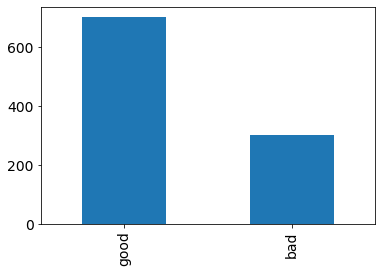

In [7]:
df['Risk'].value_counts().plot(kind ='bar')

### Explore Categorical Variables

#### Convert categorical variables with two classes to binary format
In binary format, we assign a class with label `0` and other class with `1`

In [8]:
## TO DO: Convert `Risk` and `Sex` to a binary variable
## Use .map() method and convert bad -> 0 and good -> 1 & male ->1 and female ->0

# df['Risk'] = df['Risk'].map(...)
# df['Sex'] = df['Sex'].map(...)

#### Solution
df['Risk'] = df['Risk'].map({'good':1,'bad':0})
df['Sex'] = df['Sex'].map({'male':1,'female':0})

#### Convert categorical variables with >2 classes to ordinal format
In ordinal format, we assign a number for each class starting from 0. The columns are `Job` ,  `Housing` , `Saving accounts` , `Checking account`, and `Purpose`. Let us explore each of them.

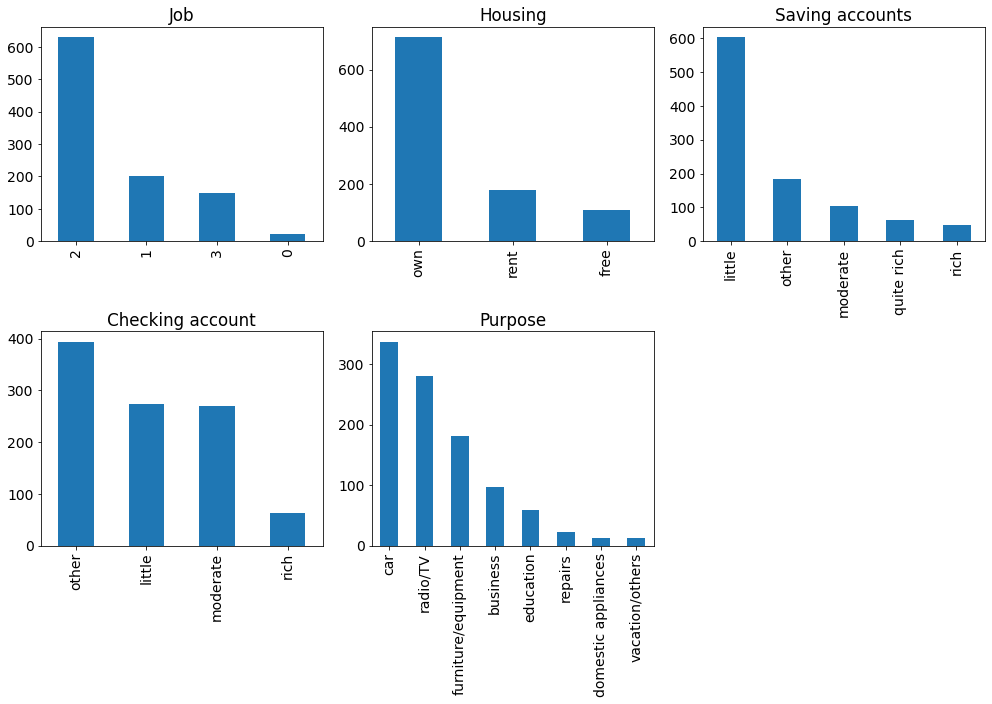

In [9]:
cat_variables = ['Job' , 'Housing' , 'Saving accounts' , 'Checking account', 'Purpose']
fig, ax = plt.subplots(nrows=2,ncols=3, figsize= (14,10))
for i,category in enumerate(cat_variables):
  j = i if i < 3 else i % 3
  df[category].value_counts().plot(kind = 'bar', ax = ax[int(i/3),j], title = category)
fig.delaxes(ax[1,2])
fig.tight_layout()

Notice that the `Job` column is already represented in an ordinal format. Let us convert the rest of them too. In order to keep track of the relationship of classe and labels, let us store the class dictionaries in `class_to_labels` variable all categories

In [10]:
class_to_labels = {}
cat_to_ordinal = ['Housing' , 'Saving accounts' , 'Checking account', 'Purpose']
for category in cat_to_ordinal:
    values = df[category].unique()
    ids = range(0,len(values))
    cat_dict = dict(zip(values,ids))
    df[category] = df[category].map(cat_dict)
    class_to_labels[category] = cat_dict

In [11]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,0,0,0,1169,6,0,1
1,22,0,2,0,1,1,5951,48,0,0
2,49,1,1,0,1,2,2096,12,1,1
3,45,1,2,1,1,0,7882,42,2,1
4,53,1,2,1,1,0,4870,24,3,0
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,0,1,2,1736,12,2,1
996,40,1,3,0,1,0,3857,30,3,1
997,38,1,2,0,1,2,804,12,0,1
998,23,1,2,1,1,0,1845,45,0,0


In [12]:
class_to_labels

{'Housing': {'own': 0, 'free': 1, 'rent': 2},
 'Saving accounts': {'other': 0,
  'little': 1,
  'quite rich': 2,
  'rich': 3,
  'moderate': 4},
 'Checking account': {'little': 0, 'moderate': 1, 'other': 2, 'rich': 3},
 'Purpose': {'radio/TV': 0,
  'education': 1,
  'furniture/equipment': 2,
  'car': 3,
  'business': 4,
  'domestic appliances': 5,
  'repairs': 6,
  'vacation/others': 7}}

## Explore Distributions

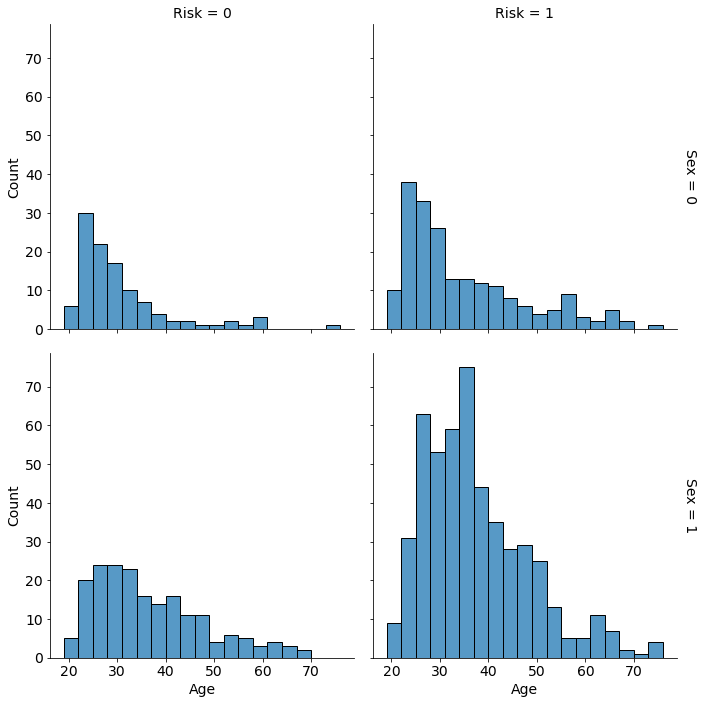

In [13]:
sns.displot(
    df, x="Age", col="Risk", row="Sex",
    binwidth=3, height=5, facet_kws=dict(margin_titles=True)
)

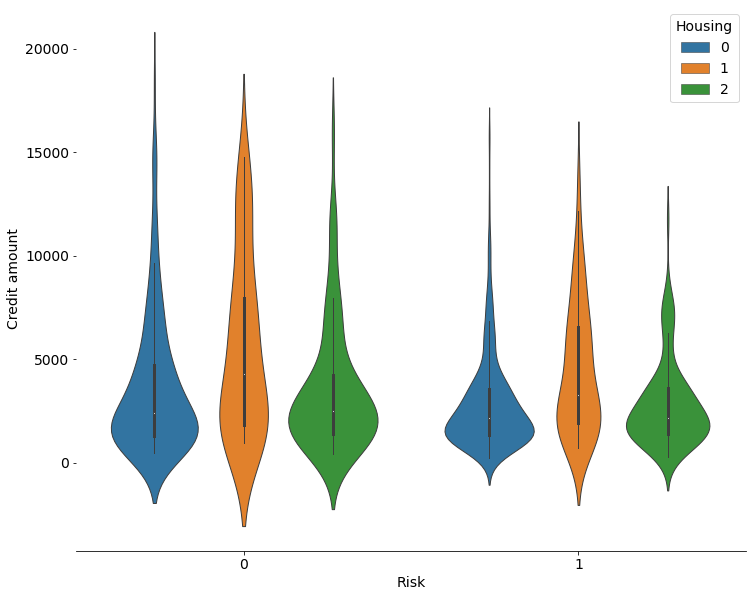

In [14]:
fig, ax = plt.subplots(figsize= (12,10))
sns.violinplot(data=df, x="Risk", y="Credit amount", hue="Housing", inner="box", linewidth=1,pallette  = 'tab10')
sns.despine(left=True)

## View Correlations

Now, let us see which attributes are correlated (positive/negative) with the `Risk`. To do this we need to convert the `Risk` to binary variable

In [15]:
## TO DO: Use `seaborn` heatmap to display the correlations. Fill in the `visualize_corr` function
## Make sure to display the annotations and colormap
def visualize_corr(df, figsize = (12,12)):
  plt.figure(figsize=figsize)
  pass


def visualize_corr(df, figsize = (12,12)):
  plt.figure(figsize=figsize)
  sns.heatmap(df.corr(), annot=True)
  plt.show()

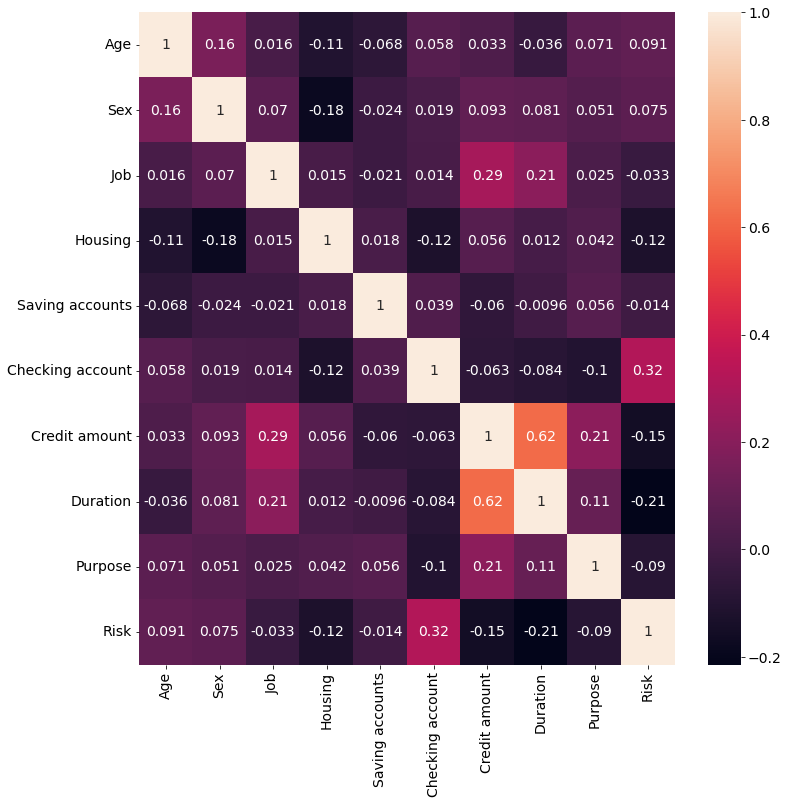

In [16]:
visualize_corr(df)

## 🚨TODO: Let's build some Intuition 🤔

<img src ='https://cdn.streamelements.com/uploads/71a1c318-9fd1-4cf1-b4ea-d090a49cb85c.gif'>

Based on the exploratory data analysis above, list the attributes/features that are most influential the deciding the `Risk` as good/bad.


1.   "List item here"
2.   "List item here"








Answer the following questions
1. List the attributes that make it less risky(good)
2. List the attributes that make it more risky(bad)
3. Did you notice any trends? Do they sound reasonable?


#🤖 Machine Learning Model
Using the manual data as input, let us build our machine learning model. We will build a Neural Network based classifiers in this section. Before we proceed, we need to normalize our numnerical variables and split the dataset into `train` and `test` with a 80:20 split 

In [17]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,0,0,0,1169,6,0,1
1,22,0,2,0,1,1,5951,48,0,0
2,49,1,1,0,1,2,2096,12,1,1
3,45,1,2,1,1,0,7882,42,2,1
4,53,1,2,1,1,0,4870,24,3,0
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,0,1,2,1736,12,2,1
996,40,1,3,0,1,0,3857,30,3,1
997,38,1,2,0,1,2,804,12,0,1
998,23,1,2,1,1,0,1845,45,0,0


In [18]:
## TODO: Scale numerical variables to [0,1] using `MinMaxScalar()` from sklearn

numeric_columns= ['Age','Credit amount','Duration']
# Scaler = ...
# df[numeric_columns] = ...

#### Solution
Scaler = MinMaxScaler()
df[numeric_columns] = Scaler.fit_transform(df[numeric_columns])


In [19]:
## Note: You can convert to the original value using the `inverse_transform`
Scaler.inverse_transform(df.head()[numeric_columns])

array([[6.700e+01, 1.169e+03, 6.000e+00],
       [2.200e+01, 5.951e+03, 4.800e+01],
       [4.900e+01, 2.096e+03, 1.200e+01],
       [4.500e+01, 7.882e+03, 4.200e+01],
       [5.300e+01, 4.870e+03, 2.400e+01]])

In [20]:
## TODO: Split the data into train and test. Initialize variables X & Y and pass into `train_test_split` function
## Make sure to fill the remaining blanks and use a random_state

# X = ...
# Y = ...
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=..., random_state=..., stratify=y)

#### Solution
x = df.drop(columns='Risk')
y = df['Risk']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2, stratify=y)

In [37]:
### Here is the function to build and train the nueral network model
tf.random.set_seed(42)

def train_tf_model(x_train, y_train, x_test, y_test):
    y_train = tf.keras.utils.to_categorical(y_train, 2)
    y_test = tf.keras.utils.to_categorical(y_test, 2)

    model = tf.keras.models.Sequential()
    ### Fill out the input size based on the number of input variables
    model.add(tf.keras.layers.Input(shape=(9,)))
    model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1,
        decay_steps=1,
        decay_rate=0.99,
        staircase=True
    )
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=learning_rate,
        momentum=0.9,
        nesterov=True
    )
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.AUC()])
    model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=0)
    train_loss, train_accuracy = model.evaluate(x_train, y_train, batch_size=51, verbose=0)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=51, verbose=0)

    print('Train loss: {:.4f}, train ROC_AUC {:.4f}'.format(train_loss, train_accuracy))
    print('Test loss:  {:.4f}, test ROC_AUC:  {:.4f}'.format(test_loss, test_accuracy))
    return model

In [38]:
## Build and train the nueral network
model_nn = train_tf_model(x_train, y_train, x_test, y_test)

Train loss: 0.5006, train ROC_AUC 0.8361
Test loss:  0.5980, test ROC_AUC:  0.7553


In [39]:
model_nn.predict(x_test[:10]).argmax(axis=-1)

1/1 [==============================] - 0s 52ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [40]:
y_test[:10]

620    1
34     1
792    1
503    0
713    1
231    1
835    0
907    1
454    0
190    0
Name: Risk, dtype: int64

# 🔄️ Generate Counterfactuals
Now that we have our ML model ready, let us generate our CounterfactualExplainer using OmnixAI library

In [41]:
## OmnixAI requires the data to be in a Tabular, Image or Text format. Let's convert our Dataframe to a Tabular format
## TODO: Pass the training data and features

# feature_names = ...

## Used for initializing the explainer
# tabular_data_train = Tabular(
#     data = ...,
#     feature_columns=feature_names
# )

# tabular_data_test = Tabular(
#     data = ...,
#     feature_columns=feature_names
# )

#### Solution
feature_names = df.drop(columns='Risk').columns
# Used for initializing the explainer
tabular_data_train  = Tabular(
    data = x_train,
    feature_columns=feature_names
)

tabular_data_test  = Tabular(
    data = x_test,
    feature_columns=feature_names
)

In [42]:
## TODO: Pass the training data and model to the Counterfactual explainer
# explainer_nn = CounterfactualExplainer(training_data=...,
#                                        predict_function=...)

#### Solution
explainer_nn = CounterfactualExplainer(training_data=tabular_data_train,
                                       predict_function=model_nn)

In [27]:
## Time to generate some counterfactuals!!!
explanations = explainer_nn.explain(tabular_data_test[:2])
explanations.ipython_plot()

Binary step: 5 |███████████████████████████████████████-| 99.9% 

In [28]:
## TODO: Find few records in the test data where the `Risk` is predicted as `bad`(0) and generate a counterfactuals
N = 1
RANDOM_STATE = 42
tab_indices = y_test[y_test == 0].sample(n=N, random_state=RANDOM_STATE).index.tolist()
print(tab_indices)
df_test = tabular_data_test.to_pd()
## Time to generate some counterfactuals!!!
explanations = explainer_nn.explain(df_test[df_test.index.isin(tab_indices)])
explanations.ipython_plot()

[503]
Binary step: 5 |███████████████████████████████████████-| 99.9% 

In [29]:
explanations.get_explanations(index=0).get('query')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,label
503,0.339286,1,2,0,4,1,0.053153,0.294118,0,1


In [30]:
explanations.get_explanations(index=0).get('counterfactual')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,label
0,0.339286,1.0,2.0,0.0,4.0,1.0,0.053153,0.295715,0.0,0


In [31]:
explanations.ipython_plot(index=0)

In [32]:
x_test[x_test.index.isin([503])]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
503,0.339286,1,2,0,4,1,0.053153,0.294118,0


In [33]:
y_test[y_test.index.isin([503])]

503    0
Name: Risk, dtype: int64

In [167]:
## TODO: Find few records in the train & test data where the `Risk` is predicted is different from our initial data
## Find counterfactuals for them

from typing import Any
import pandas as pd
import itertools

np.random.seed(RANDOM_STATE)

def find_incorrect_predictions_counterfactual_explanation(
    model: Any, X: pd.DataFrame, y: pd.Series, size: int = N
) -> None:
    """
    Find the incorrect predictions from a model and generates the counterfactual
    explanations for the particular dataset that the model was trained/evaluated on.
    
    Args:
        model: The model used for training
        X:     The dataset used on the model training/evaluation excluding the target column
        y:     The target column values of X
        size:  The size of the random samples to select from each of the false positives and false negatives.
               The bigger the size the longer the computation of the counterfactuals. 
    """
    predictions = model.predict(X).argmax(axis=-1)
    actual = y.values
    difference = actual - predictions
    false_positives = np.where(difference == -1)[0]
    false_negatives = np.where(difference == 1)[0]
    assert size < len(false_positives)
    assert size < len(false_negatives)
    random_sample_false_positives = np.random.choice(false_positives, size=size)
    random_sample_false_negatives = np.random.choice(false_negatives, size=size)
    print(random_sample_false_positives)
    print(random_sample_false_negatives)
    flattened_indices = list(
        itertools.chain.from_iterable(
            (random_sample_false_positives, random_sample_false_negatives)
        )
    )
    tab_indices = X.iloc[flattened_indices].index.tolist()
    print(tab_indices)
    explanations = explainer_nn.explain(X[X.index.isin(tab_indices)])
    for i in range(len(tab_indices)):
      explanations.ipython_plot(index=i)


In [ ]:
find_incorrect_predictions_counterfactual_explanation(model=model_nn, X=x_train, y=y_train)

In [36]:
find_incorrect_predictions_counterfactual_explanation(model=model_nn, X=x_test, y=y_test)

7/7 [==============================] - 0s 2ms/step
[62, 229]
Binary step: 5 |███████████████████████████████████████-| 99.9% 

# 🗝️Outro
Awesome! You made it till the end 👏 Answer the following questions to deepen your understanding.

1. Do you think the ML model prediction is similar to the orignal manual prediction? Do the predictions align well with your initial intuition?
2. We as humans have biases in our decision making. The biases might seep into the ML model as the models try to minimize the loss and improve accuracy. With the help of counterfactuals, did you see that the model has any inherent bias?
3. Do you think the counterfactuals serve a good tool to explain customers what they could do to achieve a better Risk profile? Give reasoning.

# Data Curation using Counterfactually Generated Data(Additional Bonus Section)

Data curation means applying an operation on the dataset like filtering or augmenting so that the model does not learn spurious patterns. For examples, if the dataset only includes women whose loan request was rejected, the model might learn that being a women causes you to be at high risk as opposed to the other factors like past credit, a/c bal etc. So to avoid such scenarios which actually happens quite frequently, we would want to include counterfactual data. That is we need examples in training that has women whose loan was approved so that the model doesn’t learn to rely on spurious features. This process is called data curation.

In [ ]:
!pip install -q ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 33.1 MB/s eta 0:00:00


In [ ]:
df = (
    x
    .assign(y_hat=model_nn.predict(x).argmax(-1))
    .assign(y=y.values)
)
df.head()

32/32 [==============================] - 0s 3ms/step


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,y_hat,y
0,0.857143,1,2,0,0,0,0.050567,0.029412,0,1,1
1,0.053571,0,2,0,1,1,0.313690,0.647059,0,0,0
2,0.535714,1,1,0,1,2,0.101574,0.117647,1,1,1
3,0.464286,1,2,1,1,0,0.419941,0.558824,2,0,1
4,0.607143,1,2,1,1,0,0.254209,0.294118,3,0,0


In [ ]:
df_inverse = df.copy()
df_inverse[numeric_columns] = Scaler.inverse_transform(df[numeric_columns])

In [ ]:
df_inverse.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,y_hat,y
0,67.0,1,2,0,0,0,1169.0,6.0,0,1,1
1,22.0,0,2,0,1,1,5951.0,48.0,0,0,0
2,49.0,1,1,0,1,2,2096.0,12.0,1,1,1
3,45.0,1,2,1,1,0,7882.0,42.0,2,0,1
4,53.0,1,2,1,1,0,4870.0,24.0,3,0,0


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_inverse, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Let us view the performance of the model against different slices of data. In this case I will define a slice as a singular feature. The performance of the model across slices is vital and usually used as an additional metric to gauge the performance of a model. In the case of credit scoring just because a model performs better overall in terms of ROC_AUC but performs worse for important slices of user groups(such as subprime/prime users) than it would less likely get approval to be put into production. 

In [158]:
from sklearn.metrics import roc_auc_score

def auc_group(df):
    y_hat = df.y_hat
    y = df.y
    try:
      return roc_auc_score(y_hat, y)
    except ValueError:
      print("Unable to compute ROC_AUC score!")

df_inverse.groupby('Sex').apply(auc_group)

Sex
0.0    0.688945
1.0    0.728264
dtype: float64

In [80]:
df_inverse.groupby('Job').apply(auc_group)

Job
0    0.763889
1    0.701897
2    0.724969
3    0.558553
dtype: float64

In [81]:
df_inverse.groupby('Saving accounts').apply(auc_group)

Saving accounts
0    0.679843
1    0.679145
2    0.614773
3    0.523810
4    0.739286
dtype: float64

In [82]:
# Highly imbalanced predictions per group which result in the 
# inability to show a ROC_AUC score for some groups
df_inverse.groupby('Checking account').apply(auc_group)

Unable to compute ROC_AUC score!


Checking account
0    0.641848
1    0.663329
2    0.942748
3         NaN
dtype: float64

In [84]:
df_inverse.groupby('Checking account').agg({'y': 'value_counts', 'y_hat': 'value_counts'})

y  y_hat
Checking account              
0                0  135  206.0
                 1  139   68.0
1                0  105   52.0
                 1  164  217.0
2                0   46    1.0
                 1  348  393.0
3                0   14    NaN
                 1   49   63.0

## Findings from EDA across Different Slices

Due to there being an insufficient number of predictions corresponding to the **Checking Account class #3** for the **Negative Target Variable** we are unable to calculate an ROC_AUC score for the Checking account. This case seems like a concrete use case to generate counterfactuals.

An additional thing to note is that the performance across the **Checking Account class 2** is quite high due to their being an imbalanced distrbution of the target variable. 

Circling back to the point about slices of data, defining important user groups to ensure sufficient model performance requires domain knowledge and proper collaboration with relevant stakeholders. In this case, I am assuming that **Checking account** performance is vital to the business, therefore we should do our best to improve the performance of the model across groups of difference Checking account's that could exist. 

Let us try generating counterfactuals for these two scenarios. 

## Methodology for Generating Counterfactual and Performing Data Curation 
Next let us create **N** more samples to add into the dataset, since generating counterfactuals is quite computationally expensive I will choose a small number such as **2%** of the **dataset size**, which is **20**(still going to take quite some time to generate them but I want to make sure I add enough examples, if I were to add 1-5 I doubt there would be enough examples for the model to learn). 

I am going to do a random sample of Checking account Class 2/3 where the ground truth is 1 and generate counterfactuals for these instances. I do so for the target class 1 as it will generate counterfactuals with the target class flipped therefore increasing the number of instances of the imbalanced cases. 

From there I will be training a new model on the dataset and compare the performance of the model across different slices.

In [91]:
N_COUNTERFACTUALS = 20
include = (2,3)
tab_indices = (
    x_test
    .assign(y=y_test.values)
    .query('(`Checking account` in @include) & (y == 1)')
    .sample(n=N_COUNTERFACTUALS, random_state=RANDOM_STATE)
    .index
    .tolist()
)
explanations_data_curation = explainer_nn.explain(df_test[df_test.index.isin(tab_indices)])

Binary step: 5 |███████████████████████████████████████-| 99.9% 

In [92]:
explanations_data_curation.ipython_plot(index=0)

So it seems that the output of the Counterfactual incorrectly creates a *Checking account class 1.15* when it is a categorical feature not a numeric feature. **Seems like a downside of using Counterfactual Explanations is that it still does not properly generate data based on the data.**

Another issue is that we are not actually generating examples for the Checking account class 2/3 here, need to find out how to allow generating multiple Counterfactuals from a query and then filtering the ones that include class 2/3 to be included in the final dataset. Doing so will also mean that the computation time will increase quadratically but is worth it to prove the point of data curation. 

A quick fix is to round the resulting Checking account values for the Counterfactuals, even then it seems to  fail at creating more instances for the *Checking account class 2/3* 😞. Maybe we should inverse all transformations done on the data before passing it throught the Counterfactual Explanation?

In [104]:
CATEGORICAL_COLUMNS = ['Sex', 'Job', 'Housing']
counterfactual_dfs = []
for explanation in explanations_data_curation.explanations:
  counterfactual = explanation.get('counterfactual')
  counterfactual[CATEGORICAL_COLUMNS] = counterfactual[CATEGORICAL_COLUMNS].round()
  counterfactual_dfs.append(counterfactual)

In [105]:
counterfactual_df = pd.concat(counterfactual_dfs)

In [110]:
counterfactual_df = counterfactual_df.reset_index(drop=True)

In [118]:
y_counterfactuals = counterfactual_df.label.values
x_counterfactuals = counterfactual_df.drop('label', axis=1)

In [135]:
x_train_counterfactuals = pd.concat([x_train, x_counterfactuals])

In [139]:
y_train_counterfactuals = pd.Series(np.concatenate((y_train.to_numpy(), y_counterfactuals)))

In [140]:
model_nn = train_tf_model(x_train_counterfactuals, y_train_counterfactuals, x_test, y_test)

Train loss: 0.4896, train ROC_AUC 0.8473
Test loss:  0.5970, test ROC_AUC:  0.7483


In [141]:
x_counterfactuals = pd.concat([x_train_counterfactuals, x_test])

In [142]:
x_counterfactuals

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
196,0.160714,0.0,2.0,0.0,1.0,2.0,0.062287,0.029412,0.0
823,0.500000,1.0,1.0,0.0,1.0,0.0,0.026466,0.058824,3.0
862,0.285714,0.0,2.0,0.0,1.0,0.0,0.120447,0.294118,0.0
90,0.660714,1.0,2.0,0.0,1.0,2.0,0.020249,0.117647,0.0
396,0.642857,0.0,3.0,1.0,1.0,0.0,0.128095,0.117647,2.0
...,...,...,...,...,...,...,...,...,...
645,0.142857,1.0,2.0,2.0,0.0,2.0,0.425333,0.470588,4.0
38,0.321429,1.0,2.0,0.0,1.0,3.0,0.053648,0.088235,5.0
745,0.160714,1.0,1.0,0.0,1.0,0.0,0.085122,0.132353,4.0
704,0.232143,0.0,2.0,0.0,1.0,1.0,0.125344,0.338235,4.0


In [149]:
y_counterfactuals = np.concatenate((y_train_counterfactuals.values, y_test.values))

In [156]:
df = (
    x_counterfactuals
    .assign(y_hat=model_nn.predict(x_counterfactuals).argmax(-1))
    .assign(y=y_counterfactuals)
)
df_inverse = df.copy()
df_inverse[numeric_columns] = Scaler.inverse_transform(df[numeric_columns])

32/32 [==============================] - 0s 4ms/step


In [159]:
df_inverse.groupby('Checking account').apply(auc_group)

Unable to compute ROC_AUC score!


Checking account
0.0    0.669103
1.0    0.697694
2.0    0.692602
3.0         NaN
dtype: float64

## Before vs After Counterfactual on Different Checking account

Before
- 0 -  0.641848
- 1 -  0.663329
- 2 -  0.942748
- 3 -       NaN

After
- 0.0 -  0.669103
- 1.0 -  0.697694
- 2.0 -  0.692602
- 3.0 -       NaN

Interesting, seems that adding Counterfactual Examples causing even worse performance of the model across Classes 2!

In [160]:
df_inverse.groupby('Job').apply(auc_group)

Job
0.0    0.661111
1.0    0.730167
2.0    0.733296
3.0    0.651864
dtype: float64

## Before vs After Counterfactual on Different Jobs

Before
- 0 - 0.763889
- 1 - 0.701897
- 2 - 0.724969
- 3 - 0.558553

After 
- 0.0 - 0.661111
- 1.0 - 0.730167
- 2.0 - 0.733296
- 3.0 - 0.651864

In [161]:
df_inverse.groupby('Saving accounts').apply(auc_group)

Saving accounts
0.0    0.730423
1.0    0.709311
2.0    0.574528
3.0    0.541860
4.0    0.753712
dtype: float64

## Before vs After Counterfactual on Different Saving accounts

Before
Saving accounts
- 0 - 0.679843
- 1 - 0.679145
- 2 - 0.614773
- 3 - 0.523810
- 4 - 0.739286

After
- 0.0 -  0.730423
- 1.0 -  0.709311
- 2.0 -  0.574528
- 3.0 -  0.541860
- 4.0 -  0.753712

In [162]:
df_inverse.groupby('Sex').apply(auc_group)

Sex
0.0    0.688945
1.0    0.728264
dtype: float64

## Before vs After Counter Factual on Different Sex

Sex
- 0 - 0.688945
- 1 - 0.728264

Sex
- 0.0 - 0.688945
- 1.0 - 0.728264



# Improvements to be made:
1. Figure out how to generate N CounterFactuals per each query. Right now it generates a single explanation and even though we try to generate them for the specific features and their respective classes that we think will help improve the model, it does not produce enough diverse data to improve the models performance.
2. Try out creating more data, perhaps 10% instead of 2% of the dataset size.

# 💰Bonus - Counterfactuals for text classification 
Let's apply counterfactuals in the context of text classification. Specifically, we will generate counter factuals for the sentiment analysis we used in Week 2 for movie reviews. We will use the same pretrained `cardiffnlp/twitter-xlm-roberta-base-sentiment` model from hugging face. The OmnixAI provides `polyjuice` explainer for counterfactuals

<center><img src='https://media1.giphy.com/media/v7yls1pusVAyo2JfPu/giphy.gif?cid=ecf05e47yq0khgmvfuggu2tukla3eavittk2oyxagnd51llz&rid=giphy.gif&ct=g'></center>

In [ ]:
!pip install transformers==4.6.0 polyjuice_nlp torch omnixai

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import torch
import transformers
from polyjuice import Polyjuice
from transformers import AutoModelForSequenceClassification
from omnixai.data.text import Text
from omnixai.explainers.nlp import NLPExplainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
## Before we build our transformer, lets make sure to setup the device.
## To run this notbeook via GPU: Edit -> Notebook settings -> Hardware accelerator -> GPU
## If your GPU is working, device is "cuda"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
name = "cardiffnlp/twitter-xlm-roberta-base-sentiment" 
# The pre- and post-processing functions
preprocess = lambda x: x.values
postprocess = lambda outputs: np.array([[s["score"] for s in ss] for ss in outputs])


##TODO: Build pre-trained model for sentiment analysis

# model = transformers.pipeline(
#     'sentiment-analysis',
#     model=...,
#     return_all_scores=...
# )

#### Solution
model = transformers.pipeline(
    'sentiment-analysis',
    model=name,
    return_all_scores=True
)

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:

# Build explainer using the NLPExplainer. Use "polyjuice" for explainer

# explainer = NLPExplainer(
#     explainers=[...],
#     mode="...",
#     model=...,
#     preprocess=...,
#     postprocess=...
# )

#### Solutions
explainer = NLPExplainer(
    explainers=[ "polyjuice"],
    mode="classification",
    model=model,
    preprocess=preprocess,
    postprocess=postprocess
)

In [ ]:
## Remember our classes for sentiment analysis are as follows
model.model.config.label2id

{'negative': 0, 'neutral': 1, 'positive': 2}

Let us use some phrases from movie reviews. Feel free to add your own or  ask ChatGPT to generate some for you😉

In [ ]:
x = Text([
    "What a great movie!",
    "The movie had great narration and visuals despite a boring storyline"
])

In [ ]:
# Generates explanations
local_explanations = explainer.explain(x)

Downloading:   0%|          | 0.00/828 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
## View explanations
local_explanations['polyjuice'].ipython_plot(index = 1)

This is the final project of the four week `Interpreting Machine Learning Models` course. We hope you had a fun learning experience. Keep engaged with the community and build it stronger💪